# This notebooks will replicate and build on the results obtained by estimating our custom Covid-19 model

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from functools import partial
import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors
import seaborn as sns
import pandas as pd
import pickle
from scipy import stats
from scipy.stats import binom, nbinom

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, LSTM
from tensorflow.keras.models import Sequential

from tqdm import tqdm

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *

In [4]:
from abf_functions import *

In [5]:
RERUN_BOOTSTRAP = True
RERUN_POWER_ANALYSIS = True

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
plt.rcParams.update({
    "axes.labelsize" : 20,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
})

FILEFORMAT = 'pdf'
DPI = 300

# Data Loading

In [8]:
confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
recovered_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
dead_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'


confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
recovered_cases = pd.read_csv(recovered_cases_url, sep=',')
dead_cases = pd.read_csv(dead_cases_url, sep=',')


date_data_begin = datetime.date(2020,3,1)
date_data_end = datetime.date(2020,5,21)


format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])
date_formatted_begin = format_date(date_data_begin)
date_formatted_end = format_date(date_data_end)

cases_obs =  np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]
recovered_obs =  np.array(
    recovered_cases.loc[recovered_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]

dead_obs =  np.array(
    dead_cases.loc[dead_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]

data_germany = np.stack([cases_obs, recovered_obs, dead_obs]).T
data_germany = np.diff(data_germany, axis=0)
T_germany = data_germany.shape[0]
N_germany = 83e6
mean_g = np.mean(data_germany, axis=0)
std_g = np.std(data_germany, axis=0)

# Epidemiological Model

In [9]:
alpha_f = (0.7**2)*((1-0.7)/(0.17**2) - (1-0.7))
beta_f = alpha_f*(1/0.7 - 1)


def prior_sir():
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """
    
    t1 = np.random.normal(loc=8, scale=3)
    t2 = np.random.normal(loc=15, scale=1)
    t3 = np.random.normal(loc=22, scale=1)
    t4 = np.random.normal(loc=66, scale=1) 
    delta_t1 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    delta_t2 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    delta_t3 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    delta_t4 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    lambd0 = np.random.lognormal(mean=np.log(1.2), sigma=0.5)
    lambd1 = np.random.lognormal(mean=np.log(0.6), sigma=0.5)
    lambd2 = np.random.lognormal(mean=np.log(0.3), sigma=0.5)
    lambd3 = np.random.lognormal(mean=np.log(0.1), sigma=0.5)
    lambd4 = np.random.lognormal(mean=np.log(0.1), sigma=0.5)
    mu = np.random.lognormal(mean=np.log(1/8), sigma=0.2)
    f_i = np.random.beta(a=alpha_f, b=beta_f)
    phi_i = stats.vonmises(kappa=0.01).rvs()
    f_r = np.random.beta(a=alpha_f, b=beta_f)
    phi_r = stats.vonmises(kappa=0.01).rvs()
    f_d = np.random.beta(a=alpha_f, b=beta_f)
    phi_d = stats.vonmises(kappa=0.01).rvs()
    D_i = np.random.lognormal(mean=np.log(8), sigma=0.2)
    D_r = np.random.lognormal(mean=np.log(8), sigma=0.2)
    D_d = np.random.lognormal(mean=np.log(8), sigma=0.2)
    E0 = np.random.gamma(shape=2, scale=30)
    scale_I = np.random.gamma(shape=1, scale=5)
    scale_R = np.random.gamma(shape=1, scale=5)
    scale_D = np.random.gamma(shape=1, scale=5)
    return [t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, 
            lambd0, lambd1, lambd2, lambd3, lambd4, mu, 
            f_i, phi_i, f_r, phi_r, f_d, phi_d, 
            D_i, D_r, D_d, E0, scale_I, scale_R, scale_D]


def prior_secir():
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """
    
    alpha = np.random.uniform(low=0.005, high=0.9)
    beta = np.random.lognormal(mean=np.log(0.25), sigma=0.3)
    gamma = np.random.lognormal(mean=np.log(1/6.5), sigma=0.5)
    eta = np.random.lognormal(mean=np.log(1/3.2), sigma=0.3)
    theta = np.random.uniform(low=1/14, high=1/3)
    delta = np.random.uniform(low=0.01, high=0.3)
    d = np.random.uniform(low=1/14, high=1/3)
    return [alpha, beta, gamma, eta, theta, delta, d]


def calc_lambda_array(sim_lag, lambd0, lambd1, lambd2, lambd3, lambd4, 
                      t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, T):
    """Computes the array of time-varying contact rates/transimission probabilities."""
    
    # Array of initial lambdas
    lambd0_arr = np.array([lambd0] * (t1+sim_lag))
    
    # Compute lambd1 array
    if delta_t1 == 1:
        lambd1_arr = np.array([lambd1] * (t2-t1))
    else:
        lambd1_arr = np.linspace(lambd0, lambd1, delta_t1)
        lambd1_arr = np.append(lambd1_arr, [lambd1] * (t2-t1-delta_t1))
        
    # Compute lambd2 array
    if delta_t2 == 1:
        lambd2_arr = np.array([lambd2] * (t3-t2))
    else:
        lambd2_arr = np.linspace(lambd1, lambd2, delta_t2)
        lambd2_arr = np.append(lambd2_arr, [lambd2] * (t3-t2-delta_t2))
        
    # Compute lambd3 array
    if delta_t3 == 1:
        lambd3_arr = np.array([lambd3] * (t4-t3))
    else:
        lambd3_arr = np.linspace(lambd3, lambd4, delta_t3)
        lambd3_arr = np.append(lambd3_arr, [lambd3] * (t4-t3-delta_t3))
        
    # Compute lambd4 array
    if delta_t4 == 1:
        lambd4_arr = np.array([lambd4] * (T-t4))
    else:
        lambd4_arr = np.linspace(lambd3, lambd4, delta_t4)
        lambd4_arr = np.append(lambd4_arr, [lambd4] * (T-t4-delta_t4))
    
    return np.r_[lambd0_arr, lambd1_arr, lambd2_arr, lambd3_arr, lambd4_arr]

    
def non_stationary_SEICR(params_sir, params_secir, N, T, sim_diff=16, observation_model=True):
    """
    Performs a forward simulation from the stationary SIR model.
    """
    
    # Extract parameters 
    t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, lambd0, lambd1, lambd2, lambd3, lambd4, mu, f_i, phi_i, f_r, phi_r, f_d, phi_d, delay_i, delay_r, delay_d, E0, scale_I, scale_R, scale_D = params_sir
    alpha, beta, gamma, eta, theta, delta, d = params_secir
    
    # Round integer parameters
    t1, t2, t3, t4 = int(round(t1)), int(round(t2)), int(round(t3)), int(round(t4))
    delta_t1, delta_t2, delta_t3, delta_t4 = int(round(delta_t1)), int(round(delta_t2)), int(round(delta_t3)), int(round(delta_t4))
    E0 = max(1, np.round(E0)) 
    delay_i = int(round(delay_i)) 
    delay_r = int(round(delay_r)) 
    delay_d = int(round(delay_d)) 
    
    # Impose constraints
    assert sim_diff > delay_i
    assert sim_diff > delay_r
    assert sim_diff > delay_d
    assert t1 > 0 and t2 > 0 and t3 > 0 and t4 > 0
    assert t1 < t2 < t3 < t4
    assert delta_t1 > 0 and delta_t2 > 0 and delta_t3 > 0 and delta_t4 > 0
    assert t2 - t1 >= delta_t1 and t3 - t2 >= delta_t2 and t4-t3 >= delta_t3 and T-t4 >= delta_t4

    # Calculate lambda arrays
    # Lambda0 is the initial contact rate which will be consecutively
    # reduced via the government measures
    sim_lag = sim_diff - 1
    lambd_arr = calc_lambda_array(sim_lag, lambd0, lambd1, lambd2, lambd3, lambd4, 
                                  t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, T)
 
    # Initial conditions
    S, E, C, I, R, D = [N-E0], [E0], [0], [0], [0], [0]
    
    # Containers
    I_news = []
    R_news = []
    D_news = []
    
    # Reported new cases
    I_data = np.zeros(T)
    R_data = np.zeros(T)
    D_data = np.zeros(T)
    fs_i = np.zeros(T)
    fs_r = np.zeros(T)
    fs_d = np.zeros(T)
 
    # Simulate T-1 tiemsteps
    for t in range(T+sim_lag):
        
        # Calculate new exposed cases
        E_new = lambd_arr[t] * ((C[t] + beta*I[t])/N)*S[t]
    
        # Remove exposed from susceptible
        S_t = S[t] - E_new
        
        # Calculate current exposed by adding new exposed and
        # subtracting the exposed becoming carriers.
        E_t = E[t] + E_new - gamma*E[t]
        
        # Calculate current carriers by adding the new exposed and subtracting
        # those who will develop symptoms and become detected and those who
        # will go through the disease asymptomatically.
        C_t = C[t] + gamma*E[t] - (1-alpha)*eta*C[t] - alpha*theta*C[t]
        
        # Calculate current infected by adding the symptomatic carriers and 
        # subtracting the dead and recovered. The newly infected are just the 
        # carriers who get detected.
        I_t = I[t] + (1-alpha)*eta*C[t] - (1-delta)*mu*I[t] - delta*d*I[t]
        I_new = (1-alpha)*eta*C[t]
        
        # Calculate current recovered by adding the symptomatic and asymptomatic
        # recovered. The newly recovered are only the detected recovered
        R_t = R[t] + alpha*theta*C[t] + (1-delta)*mu*I[t]
        R_new = (1-delta)*mu*I[t]
        
        # Calculate the current dead
        D_t = D[t] + delta*d*I[t]
        D_new = delta*d*I[t]
        
        # Ensure some numerical onstraints
        S_t = np.clip(S_t, 0, N)
        E_t = np.clip(E_t, 0, N)
        C_t = np.clip(C_t, 0, N)
        I_t = np.clip(I_t, 0, N)
        R_t = np.clip(R_t, 0, N)
        D_t = np.clip(D_t, 0, N)
        
        # Keep track of process over time
        S.append(S_t)
        E.append(E_t)
        C.append(C_t)
        I.append(I_t)
        R.append(R_t)
        D.append(D_t)
        I_news.append(I_new)
        R_news.append(R_new)
        D_news.append(D_new)
        
        # From here, start adding new cases with delay D
        # Note, we assume the same delay
        if t >= sim_lag:
            
            # Compute lags and add to data arrays
            fs_i[t-sim_lag] = (1-f_i)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_i)) )
            fs_r[t-sim_lag] = (1-f_r)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_r)) )
            fs_d[t-sim_lag] = (1-f_d)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_d)) )
            I_data[t-sim_lag] = I_news[t-delay_i]
            R_data[t-sim_lag] = R_news[t-delay_r]
            D_data[t-sim_lag] = D_news[t-delay_d]
            
    # Compute weekly modulation
    I_data = (1-fs_i) * I_data
    R_data = (1-fs_r) * R_data
    D_data = (1-fs_d) * D_data
    
    # Add noise
    I_data = stats.t(df=4, loc=I_data, scale=np.sqrt(I_data)*scale_I).rvs()
    R_data = stats.t(df=4, loc=R_data, scale=np.sqrt(R_data)*scale_R).rvs()
    D_data = stats.t(df=4, loc=D_data, scale=np.sqrt(D_data)*scale_D).rvs()
    
    if observation_model:
        return np.stack((I_data, R_data, D_data)).T
    return np.stack((S, E, I, C, R, D)).T

In [10]:
def data_generator(n_sim, n_obs, N=None, sim_diff=21, N_min=10000, N_max=70000000):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    """
    
    # Variable size N
    if N is None:
        N = np.random.randint(N_min, N_max)
        
    # Generate data
    # x is a np.ndarray of shape (batch_size, n_obs, x_dim)
    x = []
    theta = []
    for i in range(n_sim):
        
        # Reject meaningless simulaitons
        x_i = None
        while x_i is None:
            try:
                theta1 = prior_sir()
                theta2 = prior_secir()
                x_i = non_stationary_SEICR(theta1, theta2, N, n_obs, sim_diff=sim_diff)
                x_i = (x_i - mean_g) / std_g
            except:
                 pass
        # Simulate SECIR
        x.append(x_i)
        theta.append(theta1 + theta2)
    x = np.array(x)
    theta = np.array(theta)

    # Convert to tensor, if specified 
    return theta.astype(np.float32), x.astype(np.float32)

In [11]:
param_names = [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$',
               r'$\Delta t_1$', r'$\Delta t_2$', r'$\Delta t_3$', r'$\Delta t_4$',
               r'$\lambda_0$', r'$\lambda_1$', r'$\lambda_2$', r'$\lambda_3$', r'$\lambda_4$', 
               r'$\mu$', r'$f_I$', r'$\phi_I$',  r'$f_R$', r'$\phi_R$',  
               r'$f_D$', r'$\phi_D$',
               r'$L_I$', r'$L_R$', r'$L_D$', r'$E_0$', r'$\sigma_I$', r'$\sigma_R$', r'$\sigma_D$', 
               r'$\alpha$', r'$\beta$', r'$\gamma$',
               r'$\eta$', r'$\theta$', r'$\delta$', r'$d$']

In [12]:
data_gen = partial(data_generator, N=N_germany, sim_diff=16)

# Network Definition

In [13]:
class MultiConvLayer(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""
    def __init__(self, n_filters=32, strides=1):
        super(MultiConvLayer, self).__init__()
        
        self.convs = [
            Conv1D(n_filters//2, kernel_size=f, strides=strides, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform')
            for f in range(2, 8)
        ]
        self.dim_red = Conv1D(n_filters, 1, 1, activation='relu', kernel_initializer='glorot_uniform')
        
    def call(self, x):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        out = tf.concat([conv(x) for conv in self.convs], axis=-1)
        out = self.dim_red(out)
        return out
    
    
class MultiConvNet(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""
    def __init__(self, n_layers=3, n_filters=64, strides=1):
        super(MultiConvNet, self).__init__()
        
        self.net = Sequential([
            MultiConvLayer(n_filters, strides)
            for _ in range(n_layers)
        ])
        
        self.lstm = LSTM(n_filters)
        
    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        out = self.net(x)
        out = self.lstm(out)
        return out
    
    
class SummaryNet(tf.keras.Model):
    def __init__(self, n_summary=192):
        super(SummaryNet, self).__init__()
        self.net_I = MultiConvNet(n_filters=n_summary//3)
        self.net_R = MultiConvNet(n_filters=n_summary//3)
        self.net_D = MultiConvNet(n_filters=n_summary//3)
    
    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        x = tf.split(x, 3, axis=-1)
        x_i = self.net_I(x[0])
        x_r = self.net_R(x[1])
        x_d = self.net_D(x[2])
        return tf.concat([x_i, x_r, x_d], axis=-1)

In [14]:
meta_dict={
    'n_coupling_layers': 6,
    's_args': {
        'units': [192, 192, 192],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [192, 192, 192],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'alpha': 1.9,
    'use_permutation': True,
    'use_act_norm': True,
    'n_params': len(param_names),
}


summary_net = SummaryNet()
inference_net = InvertibleNetwork(meta_dict)
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Trainer

In [18]:
starter_learning_rate = 0.0005
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    starter_learning_rate,
    decay_steps=1000,
    decay_rate=0.99,
    staircase=True
)


trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=data_gen,
    loss=partial(mmd_kl_loss, kernel = "inverse_multiquadratic"),
    learning_rate=learning_rate,
    checkpoint_path=f'export_ckpt/mmd_inverse_quadratic/covid19',
    max_to_keep=1,
    skip_checks=True
)

Networks loaded from export_ckpt/mmd_inverse_quadratic/covid19\ckpt-50


## Online Training

In [ ]:
%%time
losses = trainer.train_online(epochs=38, iterations_per_epoch=1000, batch_size=64, n_obs=T_germany)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/1000 [00:00<?, ?it/s]

# PCA

In [19]:
from sklearn.decomposition import PCA

In [20]:
_, x = trainer._forward_inference(10000, T_germany)
s = np.array(trainer.network.summary_net(x))

K = 192

pca = PCA(K)
pca.fit(s)

cumsum_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

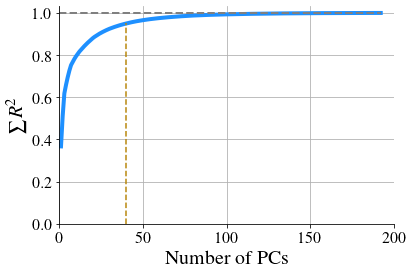

In [21]:
plt.plot(range(1, K+1), cumsum_explained_variance_ratio, linewidth=4, color="dodgerblue")
plt.xlabel("Number of PCs")
plt.ylabel(r"$\sum R^2$")
plt.ylim(0)
plt.xlim(0, 200)
plt.plot([0, 192], [1, 1], linestyle="dashed", color="grey", linewidth=2)
plt.plot([40, 40], [0, 0.95], linestyle="dashed", color="darkgoldenrod")

plt.grid()
sns.despine()
plt.savefig(f"inverse_multiquadratic/plots/COVID_PCA_explained_variance.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

In [22]:
cumsum_explained_variance_ratio[40]

0.9520579

In [23]:
"""

# Generate data from trainer's generative model
_, x = trainer._forward_inference(1000, T_germany)
s = np.array(trainer.network.summary_net(x))

# Fit PCA to data from trainer
pca = PCA(2)
pca.fit(s)


# Generate more data from trainer's generative model
_, x_star = trainer._forward_inference(1000, T_germany)
s_star = trainer.network.summary_net(x_star)

# Project all candidate data onto the Principal Components
s_star_proj = pca.transform(s_star)
s_star_test_proj = pca.transform(s_star_test)
s_1_proj = pca.transform(s_1)
s_2_proj = pca.transform(s_2)
s_3_proj = pca.transform(s_3)


S = [s_star_proj, s_star_test_proj, s_1_proj, s_2_proj, s_3proj]
TASK_NAMES = ['x_star', 'x_star_test', 'x_1', 'x_2', 'x_3']

DF = (pd.DataFrame(s, 
                     columns=[r'$Proj_{%i}$'%i for i in range(1, 3)]) for s in S)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['Model', None]
              ).reset_index(level=0)

g = sns.PairGrid(df, hue="Model", palette=['red', 'orange', 'green', 'blue', 'brown'], height=3)

g.map_upper(plt.scatter, alpha=0.1)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot, alpha=0.50)

g.add_legend()
plt.setp(g._legend.get_title(), fontsize=16)
plt.setp(g._legend.get_texts(), fontsize=14)

"""

'\n\n# Generate data from trainer\'s generative model\n_, x = trainer._forward_inference(1000, T_germany)\ns = np.array(trainer.network.summary_net(x))\n\n# Fit PCA to data from trainer\npca = PCA(2)\npca.fit(s)\n\n\n# Generate more data from trainer\'s generative model\n_, x_star = trainer._forward_inference(1000, T_germany)\ns_star = trainer.network.summary_net(x_star)\n\n# Project all candidate data onto the Principal Components\ns_star_proj = pca.transform(s_star)\ns_star_test_proj = pca.transform(s_star_test)\ns_1_proj = pca.transform(s_1)\ns_2_proj = pca.transform(s_2)\ns_3_proj = pca.transform(s_3)\n\n\nS = [s_star_proj, s_star_test_proj, s_1_proj, s_2_proj, s_3proj]\nTASK_NAMES = [\'x_star\', \'x_star_test\', \'x_1\', \'x_2\', \'x_3\']\n\nDF = (pd.DataFrame(s, \n                     columns=[r\'$Proj_{%i}$\'%i for i in range(1, 3)]) for s in S)\n\ndf = pd.concat(DF,\n              keys=TASK_NAMES,\n              names=[\'Model\', None]\n              ).reset_index(level=0)\n\ng

### Separate PCAs

In [24]:
"""

# Generate data from trainer's generative model
_, x_star = trainer._forward_inference(1000, T_germany)
s_star = trainer.network.summary_net(x_star)

# Fit and project all data on separate PCAs based on them
s_star_proj = PCA(2).fit_transform(s_star)
s_star_test_proj = PCA(2).fit_transform(s_star_test)
s_1_proj = PCA(2).fit_transform(s_1)
s_2_proj = PCA(2).fit_transform(s_2)
s_3_proj = PCA(2).fit_transform(s_3)


S = [s_star_proj, s_star_test_proj, s_1_proj, s_2_proj, s_3_proj]
TASK_NAMES = ['x_star', 'x_star_test', 'x_1', 'x_2', 'x_3']

DF = (pd.DataFrame(s, 
                     columns=[r'$Proj_{%i}$'%i for i in range(1, 3)]) for s in S)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['Model', None]
              ).reset_index(level=0)

g = sns.PairGrid(df, hue="Model", palette=['red', 'orange', 'green', 'blue', 'brown'], height=3)

g.map_upper(plt.scatter, alpha=0.1)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot, alpha=0.50)

g.add_legend()
plt.setp(g._legend.get_title(), fontsize=16)
plt.setp(g._legend.get_texts(), fontsize=14)

"""

'\n\n# Generate data from trainer\'s generative model\n_, x_star = trainer._forward_inference(1000, T_germany)\ns_star = trainer.network.summary_net(x_star)\n\n# Fit and project all data on separate PCAs based on them\ns_star_proj = PCA(2).fit_transform(s_star)\ns_star_test_proj = PCA(2).fit_transform(s_star_test)\ns_1_proj = PCA(2).fit_transform(s_1)\ns_2_proj = PCA(2).fit_transform(s_2)\ns_3_proj = PCA(2).fit_transform(s_3)\n\n\nS = [s_star_proj, s_star_test_proj, s_1_proj, s_2_proj, s_3_proj]\nTASK_NAMES = [\'x_star\', \'x_star_test\', \'x_1\', \'x_2\', \'x_3\']\n\nDF = (pd.DataFrame(s, \n                     columns=[r\'$Proj_{%i}$\'%i for i in range(1, 3)]) for s in S)\n\ndf = pd.concat(DF,\n              keys=TASK_NAMES,\n              names=[\'Model\', None]\n              ).reset_index(level=0)\n\ng = sns.PairGrid(df, hue="Model", palette=[\'red\', \'orange\', \'green\', \'blue\', \'brown\'], height=3)\n\ng.map_upper(plt.scatter, alpha=0.1)\ng.map_diag(sns.kdeplot)\ng.map_lower

# Bootstrapping

In [25]:
from tqdm.notebook import tqdm
import pickle

In [26]:
with open('inverse_multiquadratic/data/COVID_model_data/data_model_star_test.pkl', 'rb') as f:
    x_star_test = pickle.load(f)['x']
with open('inverse_multiquadratic/data/COVID_model_data/data_model_1.pkl', 'rb') as f:
    x_1 = pickle.load(f)['x']
with open('inverse_multiquadratic/data/COVID_model_data/data_model_2.pkl', 'rb') as f:
    x_2 = pickle.load(f)['x']
with open('inverse_multiquadratic/data/COVID_model_data/data_model_3.pkl', 'rb') as f:
    x_3 = pickle.load(f)['x']

_, x_star = trainer._forward_inference(1000, T_germany)

In [27]:
def MMD_bootstrap(x_star, x_test, N_BOOTSTRAP_ITERATIONS=10, n_samples_star=1000, n_samples_test=1000):
    n_star = x_star.shape[0]
    n_test = x_test.shape[0]
    
    MMD_bootstrap = np.empty(N_BOOTSTRAP_ITERATIONS)

    for i in tqdm(range(N_BOOTSTRAP_ITERATIONS)):
        idx_star = np.random.randint(0, n_star, size=n_samples_star)
        idx_test = np.random.randint(0, n_test, size=n_samples_test)
        
        x_star_bootstrap = x_star[idx_star]
        x_test_bootstrap = x_test[idx_test]
        
        s_star_bootstrap = np.array(trainer.network.summary_net(x_star_bootstrap))
        s_test_bootstrap = np.array(trainer.network.summary_net(x_test_bootstrap))
        
        MMD_bootstrap[i] = float(maximum_mean_discrepancy(s_star_bootstrap, s_test_bootstrap, squared=False, kernel="inverse_multiquadratic"))
        
    return MMD_bootstrap

In [28]:
def calculate_CI(x, ci_area=0.95):
    q_lower = round((1.0 - ci_area) / 2, 5)
    q_upper = round(1.0 - q_lower, 5)
    return np.quantile(x, q_lower), np.quantile(x, q_upper)

In [29]:
n_samples_star = 1000
N_BOOTSTRAP_ITERATIONS = 100

for n_samples_test in [1,2,5]:
    if RERUN_BOOTSTRAP:
        print(f"Started Bootstrap for n_samples_test={n_samples_test}")
        MMD_star_bootstrap = MMD_bootstrap(x_star, x_star_test, N_BOOTSTRAP_ITERATIONS=N_BOOTSTRAP_ITERATIONS, n_samples_star=n_samples_star, n_samples_test=n_samples_test)
        MMD_1_bootstrap    = MMD_bootstrap(x_star, x_1,         N_BOOTSTRAP_ITERATIONS=N_BOOTSTRAP_ITERATIONS, n_samples_star=n_samples_star, n_samples_test=n_samples_test)
        MMD_2_bootstrap    = MMD_bootstrap(x_star, x_2,         N_BOOTSTRAP_ITERATIONS=N_BOOTSTRAP_ITERATIONS, n_samples_star=n_samples_star, n_samples_test=n_samples_test)
        MMD_3_bootstrap    = MMD_bootstrap(x_star, x_3,         N_BOOTSTRAP_ITERATIONS=N_BOOTSTRAP_ITERATIONS, n_samples_star=n_samples_star, n_samples_test=n_samples_test)

        np.save(f"inverse_multiquadratic/data/MMD_bootstrapping/MMD_star_bootstrap_N{n_samples_test}.npy", MMD_star_bootstrap)
        np.save(f"inverse_multiquadratic/data/MMD_bootstrapping/MMD_1_bootstrap_N{n_samples_test}.npy", MMD_1_bootstrap)
        np.save(f"inverse_multiquadratic/data/MMD_bootstrapping/MMD_2_bootstrap_N{n_samples_test}.npy", MMD_2_bootstrap)
        np.save(f"inverse_multiquadratic/data/MMD_bootstrapping/MMD_3_bootstrap_N{n_samples_test}.npy", MMD_3_bootstrap)
    
    MMD_star_bootstrap = np.load(f"inverse_multiquadratic/data/MMD_bootstrapping/MMD_star_bootstrap_N{n_samples_test}.npy")
    MMD_1_bootstrap = np.load(f"inverse_multiquadratic/data/MMD_bootstrapping/MMD_1_bootstrap_N{n_samples_test}.npy")
    MMD_2_bootstrap = np.load(f"inverse_multiquadratic/data/MMD_bootstrapping/MMD_2_bootstrap_N{n_samples_test}.npy")
    MMD_3_bootstrap = np.load(f"inverse_multiquadratic/data/MMD_bootstrapping/MMD_3_bootstrap_N{n_samples_test}.npy")
    MMDs_bootstrap = [MMD_star_bootstrap, MMD_1_bootstrap, MMD_2_bootstrap, MMD_3_bootstrap]

    for i, MMD_b in zip(["star", "1", "2", "3"], MMDs_bootstrap):
        lower_bound, upper_bound = calculate_CI(MMD_b, ci_area=0.95)
        median = np.median(MMD_b)
        print(f"N = {n_samples_test}:   M{i}: {median:.2f} [{lower_bound:.2f}, {upper_bound:.2f}]")

Started Bootstrap for n_samples_test=1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

N = 1:   Mstar: 3.63 [3.57, 3.74]
N = 1:   M1: 3.71 [3.63, 3.75]
N = 1:   M2: 3.75 [3.66, 3.78]
N = 1:   M3: 3.72 [3.69, 3.76]
Started Bootstrap for n_samples_test=2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

N = 2:   Mstar: 2.56 [2.50, 2.75]
N = 2:   M1: 2.86 [2.59, 3.21]
N = 2:   M2: 2.75 [2.61, 2.90]
N = 2:   M3: 2.77 [2.66, 3.14]
Started Bootstrap for n_samples_test=5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

N = 5:   Mstar: 1.68 [1.59, 1.95]
N = 5:   M1: 2.14 [1.82, 2.49]
N = 5:   M2: 1.90 [1.77, 2.03]
N = 5:   M3: 2.17 [2.00, 2.40]


In [30]:
"""
MMDs = [MMD_star, MMD_1, MMD_2, MMD_3]
MMD_bootstraps = [MMD_star_bootstrap, MMD_1_bootstrap, MMD_2_bootstrap, MMD_3_bootstrap]
colors = ["red", "firebrick", "orange", "blue"]

fig, ax = plt.subplots()

for i in range(4):
    sns.kdeplot(MMD_bootstraps[i], ax=ax, label=f"M{i}")
    ax.legend()
    ax.set_title(r"$\widehat{rMMD}$ for 100 bootstraps of $x^*$ and $x_{test}$")
    ax.set_xlabel(r"$\widehat{rMMD}$")
"""

'\nMMDs = [MMD_star, MMD_1, MMD_2, MMD_3]\nMMD_bootstraps = [MMD_star_bootstrap, MMD_1_bootstrap, MMD_2_bootstrap, MMD_3_bootstrap]\ncolors = ["red", "firebrick", "orange", "blue"]\n\nfig, ax = plt.subplots()\n\nfor i in range(4):\n    sns.kdeplot(MMD_bootstraps[i], ax=ax, label=f"M{i}")\n    ax.legend()\n    ax.set_title(r"$\\widehat{rMMD}$ for 100 bootstraps of $x^*$ and $x_{test}$")\n    ax.set_xlabel(r"$\\widehat{rMMD}$")\n'

## Power Analysis for $N=1,2,5$

In [31]:
data_gen_star = data_gen
from covid_models.covid19_ablation_intervention import data_gen as data_gen_1
from covid_models.covid19_ablation_observation import data_gen as data_gen_2
from covid_models.covid19_ablation_carrier import data_gen as data_gen_3

In [32]:
def MMD_power_analysis_generic(G_star, N_star, G_test, N_test, summary_network, number_power_simulations, number_H0_simulations=1000, n_obs=None, alpha=.05):
    # Calculate MMD_H0: Simulate MMD(A|B) with A~G_star and B~G_star
    MMD_H0 = np.empty(number_H0_simulations)
    _, x_star = G_star(N_star, n_obs)
    s_star = summary_network(x_star)
    for i in tqdm(range(number_H0_simulations), desc="Compute MMD under H0"):
        _, x_star_prime = G_star(N_test, n_obs)
        s_star_prime = summary_network(x_star_prime)
        MMD_H0[i] = float(maximum_mean_discrepancy(s_star, s_star_prime, squared=False, kernel="inverse_multiquadratic"))
    
    
    # Simulate data from the test model and compare its MMDs against H0 MMD disto
    MMDs_test = np.empty(number_power_simulations)
    _, x_star = G_star(N_star, n_obs)
    s_star = summary_network(x_star)
    for i in tqdm(range(number_power_simulations), desc="Simulate data from G_test and compute MMD"):
        _, x_test = G_test(N_test, n_obs)
        s_test = summary_network(x_test)
        
        MMDs_test[i] = float(maximum_mean_discrepancy(s_star, s_test, squared=False, kernel="inverse_multiquadratic"))

    MMD_critical = np.quantile(MMD_H0, 1-alpha)    
    power = (MMDs_test > MMD_critical).mean()      

    return {"power" : power,
            "MMD_H0" : MMD_H0,
            "MMDs_test" : MMDs_test,
            "MMD_critical" : MMD_critical,
            "alpha" : alpha,
            "N" : N_test
           }

In [33]:
if RERUN_POWER_ANALYSIS:
    N_star = 1000
    N_test = 1
    number_power_simulations = 1000
    number_H0_simulations = 1000

    models = [1, 2, 3]
    for model in models:
        print(f"Power analysis for model {model}")
        data_gen = globals()[f"data_gen_{model}"]
        power_result = MMD_power_analysis_generic(
            G_star = trainer._forward_inference,
            N_star = N_star,
            G_test = data_gen,
            N_test = N_test,
            summary_network = trainer.network.summary_net,
            number_power_simulations = number_power_simulations,
            number_H0_simulations = number_H0_simulations,
            n_obs = T_germany
            )

        with open(f"inverse_multiquadratic/data/COVID_power/covid_power_N{N_test}_M{model}.pkl", 'wb') as f:
            pickle.dump(power_result, f)

Power analysis for model 1


Compute MMD under H0:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulate data from G_test and compute MMD:   0%|          | 0/1000 [00:00<?, ?it/s]

Power analysis for model 2


Compute MMD under H0:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulate data from G_test and compute MMD:   0%|          | 0/1000 [00:00<?, ?it/s]

Power analysis for model 3


Compute MMD under H0:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulate data from G_test and compute MMD:   0%|          | 0/1000 [00:00<?, ?it/s]

In [34]:
if RERUN_POWER_ANALYSIS:
    N_star = 1000
    N_test = 2
    number_power_simulations = 1000
    number_H0_simulations = 1000

    models = [1, 2, 3]
    for model in models:
        print(f"Power analysis for model {model}")
        data_gen = globals()[f"data_gen_{model}"]
        power_result = MMD_power_analysis_generic(
            G_star = trainer._forward_inference,
            N_star = N_star,
            G_test = data_gen,
            N_test = N_test,
            summary_network = trainer.network.summary_net,
            number_power_simulations = number_power_simulations,
            number_H0_simulations = number_H0_simulations,
            n_obs = T_germany
            )

        with open(f"inverse_multiquadratic/data/COVID_power/covid_power_N{N_test}_M{model}.pkl", 'wb') as f:
            pickle.dump(power_result, f)

Power analysis for model 1


Compute MMD under H0:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulate data from G_test and compute MMD:   0%|          | 0/1000 [00:00<?, ?it/s]

Power analysis for model 2


Compute MMD under H0:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulate data from G_test and compute MMD:   0%|          | 0/1000 [00:00<?, ?it/s]

Power analysis for model 3


Compute MMD under H0:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulate data from G_test and compute MMD:   0%|          | 0/1000 [00:00<?, ?it/s]

In [35]:
if RERUN_POWER_ANALYSIS:
    N_star = 1000
    N_test = 5
    number_power_simulations = 1000
    number_H0_simulations = 1000

    models = [1, 2, 3]
    for model in models:
        print(f"Power analysis for model {model}")
        data_gen = globals()[f"data_gen_{model}"]
        power_result = MMD_power_analysis_generic(
            G_star = trainer._forward_inference,
            N_star = N_star,
            G_test = data_gen,
            N_test = N_test,
            summary_network = trainer.network.summary_net,
            number_power_simulations = number_power_simulations,
            number_H0_simulations = number_H0_simulations,
            n_obs = T_germany
            )

        with open(f"inverse_multiquadratic/data/COVID_power/covid_power_N{N_test}_M{model}.pkl", 'wb') as f:
            pickle.dump(power_result, f)

Power analysis for model 1


Compute MMD under H0:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulate data from G_test and compute MMD:   0%|          | 0/1000 [00:00<?, ?it/s]

Power analysis for model 2


Compute MMD under H0:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulate data from G_test and compute MMD:   0%|          | 0/1000 [00:00<?, ?it/s]

Power analysis for model 3


Compute MMD under H0:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulate data from G_test and compute MMD:   0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
def fill_area_under_kde(kde_object, x_start, x_end=None, **kwargs):
    kde_x, kde_y = kde_object.lines[0].get_data()
    if x_end is not None:
        plt.fill_between(kde_x, kde_y, where=(kde_x>=x_start) & (kde_x<=x_end), 
                    interpolate=True, **kwargs)
    else:
        plt.fill_between(kde_x, kde_y, where=(kde_x>=x_start), 
                    interpolate=True, **kwargs)


def print_powers(N_test, models=[1,2,3], xlims=(None, None)):
    H0_color = "#287D8EFF"
    model_color = "#55C667FF"
    alpha_color = "#481567FF"
    
    for model in models:
        with open(f"inverse_multiquadratic/data/COVID_power/covid_power_N{N_test}_M{model}.pkl", "rb") as f:
            power_result = pickle.load(f)

        MMD_H0 = power_result["MMD_H0"]
        MMDs_test = power_result["MMDs_test"]
        MMD_critical = power_result["MMD_critical"]
        

        
        fig, ax = plt.subplots(figsize=(8,4))
        kde_H0 = sns.kdeplot(MMD_H0, linewidth=3, label=r"$H_0$", color=H0_color)
        sns.kdeplot(MMD_H0, fill=True, alpha=.12, color = H0_color)
        
        kde_test = sns.kdeplot(MMDs_test, ax=ax, linewidth=3, label=r"$\mathcal{M}_{%d}$"%model, color=model_color)
        sns.kdeplot(MMDs_test, fill=True, alpha=.12, color = model_color)
        
        fill_area_under_kde(kde_H0, MMD_critical, color=alpha_color, alpha=0.7, label=r"5\% rejection area")
        
        #ax.set_title(r'Model $\mathcal{M}_%d, N=%d: 1-\beta=%.3f$'%(model, N_test, power_result["power"]), fontsize=16)
        ax.set_xlabel(r"$\widehat{\mathrm{rMMD}}$")
        ax.set_ylabel("")
        ax.set_yticks([])
        ax.set_xlim(*xlims)

        #ax.legend(fontsize=16)
        sns.despine()
        plt.savefig(f"inverse_multiquadratic/plots/COVID_power_N{N_test}_M{model}.{FILEFORMAT}", bbox_inches="tight")
        
    # save legend separately
    plt.figure(figsize=(0.1,0.1))
    plt.gca().set_axis_off()
    handles = [mpatches.Patch(facecolor=H0_color, 
                              #label=r"$\hat{p}(\widehat{\mathrm{rMMD}}\,|\,H_0)$")
                              label = r"$\widehat{\mathrm{rMMD}}$ under $H_0$"),
               mpatches.Patch(facecolor=model_color,
                              #label=r"$\hat{p}(\widehat{\mathrm{rMMD}}\,|\,{\fontfamily{cm}\selectfont\mathcal{M}}_j)$")
                              label = r"$\widehat{\mathrm{rMMD}}$ under the (misspecified) model"),
               mpatches.Patch(facecolor=alpha_color, label=r"$H_0$ rejection area")]
    plt.legend(handles=handles, loc="center", ncol=3, title="" ,fontsize=20, labelspacing=2)

    plt.savefig(f"inverse_multiquadratic/plots/COVID_power_legend.{FILEFORMAT}", bbox_inches="tight")

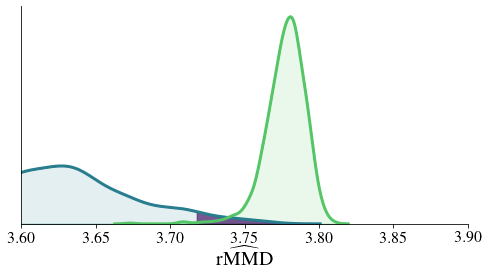

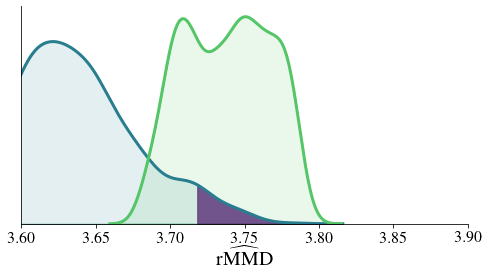

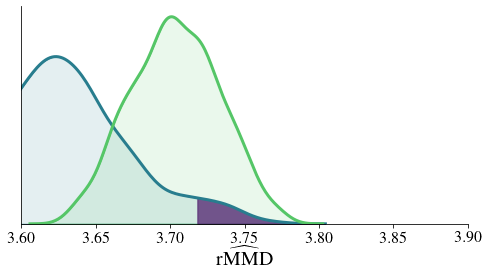

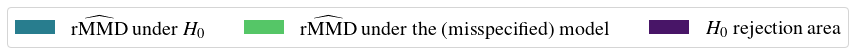

In [37]:
print_powers(N_test=1, xlims=(3.6, 3.9))

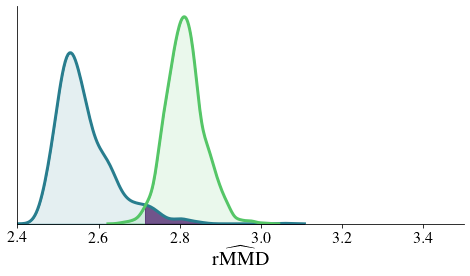

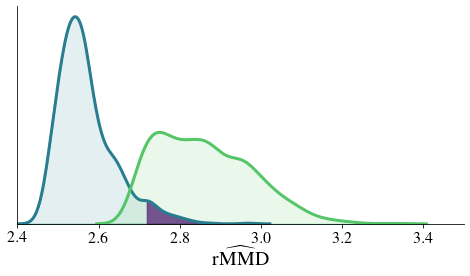

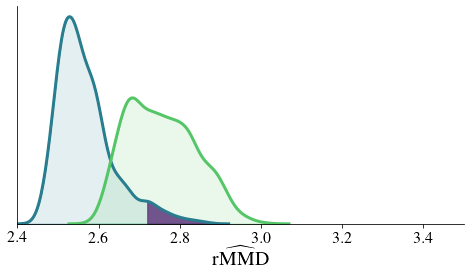

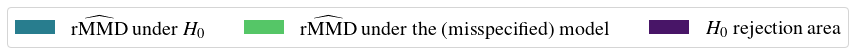

In [38]:
print_powers(N_test=2, xlims=(2.4, 3.5))

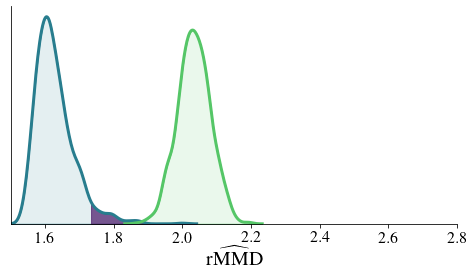

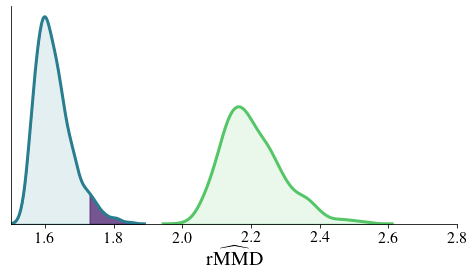

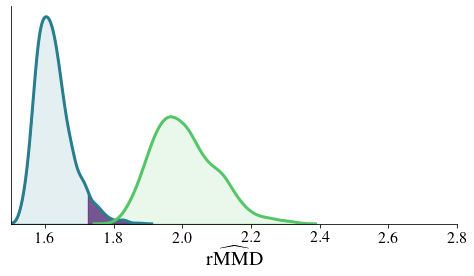

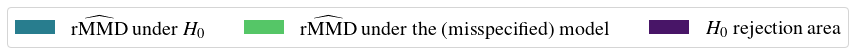

In [39]:
print_powers(N_test=5, xlims=(1.5, 2.8))

## Real Data w.r.t. $MMD|H_0$

In [40]:
confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
recovered_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
dead_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'


confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
recovered_cases = pd.read_csv(recovered_cases_url, sep=',')
dead_cases = pd.read_csv(dead_cases_url, sep=',')


date_data_begin = datetime.date(2020,3,1)
date_data_end = datetime.date(2020,5,21)


format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])
date_formatted_begin = format_date(date_data_begin)
date_formatted_end = format_date(date_data_end)

cases_obs =  np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]
recovered_obs =  np.array(
    recovered_cases.loc[recovered_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]

dead_obs =  np.array(
    dead_cases.loc[dead_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]

data_germany = np.stack([cases_obs, recovered_obs, dead_obs]).T
data_germany = np.diff(data_germany, axis=0)
T_germany = data_germany.shape[0]
N_germany = 83e6
mean_g = np.mean(data_germany, axis=0)
std_g = np.std(data_germany, axis=0)

data_germany_tensor = data_germany[np.newaxis, ...]
data_germany_tensor.shape
data_germany_standardized = (data_germany_tensor - mean_g) / std_g

In [41]:
n_obs = T_germany
N_star = 1000
N_test = 1
number_H0_simulations = 10000
G_star = data_gen_star
summary_network = trainer.network.summary_net

# Calculate MMD_H0: Simulate MMD(A|B) with A~G_star and B~G_star
MMD_H0 = np.empty(number_H0_simulations)
_, x_star = G_star(N_star, n_obs)
s_star = summary_network(x_star)

In [42]:
for i in tqdm(range(number_H0_simulations), desc="Compute MMD under H0"):
    _, x_star_prime = G_star(N_test, n_obs)
    s_star_prime = summary_network(x_star_prime)
    MMD_H0[i] = float(maximum_mean_discrepancy(s_star, s_star_prime, squared=False, kernel="inverse_multiquadratic"))
    
np.save("inverse_multiquadratic/data/COVID_real_world_analysis/MMD_H0_N1.npy", MMD_H0)
np.save("inverse_multiquadratic/data/COVID_real_world_analysis/MMD_H0_N1_x_star.npy", x_star)

Compute MMD under H0:   0%|          | 0/10000 [00:00<?, ?it/s]

In [43]:
MMD_H0 = np.load("inverse_multiquadratic/data/COVID_real_world_analysis/MMD_H0_N1.npy")
x_star = np.load("inverse_multiquadratic/data/COVID_real_world_analysis/MMD_H0_N1_x_star.npy")

s_germany_standardized = np.array(trainer.network.summary_net(data_germany_standardized))
s_germany_standardized.shape
MMD_germany_standardized = float(maximum_mean_discrepancy(s_germany_standardized, s_star, squared=False, kernel="inverse_multiquadratic"))

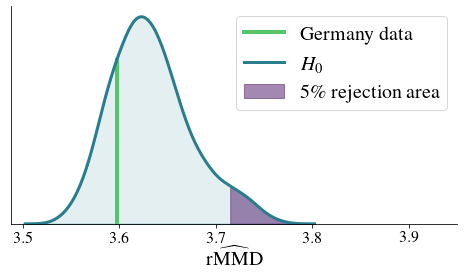

In [44]:
def draw_vline_to_kde(x, kde_object, color, **kwargs):
    kde_x, kde_y = kde_object.lines[0].get_data()
    idx = np.argmin(np.abs(kde_x - x))
    plt.plot([x, x], [0, kde_y[idx]], color=color, linewidth=4, **kwargs)
    
def fill_area_under_kde(kde_object, x_start, x_end=None, **kwargs):
    kde_x, kde_y = kde_object.lines[0].get_data()
    if x_end is not None:
        plt.fill_between(kde_x, kde_y, where=(kde_x>=x_start) & (kde_x<=x_end), 
                    interpolate=True, **kwargs)
    else:
        plt.fill_between(kde_x, kde_y, where=(kde_x>=x_start), 
                    interpolate=True, **kwargs)


bw_factor = 1.5
plt.figure(figsize=(8, 4))
alpha = 0.05
H0_color = "#287D8EFF"
data_germany_color = "#55C667FF"
alpha_color = "#481567FF"

kde = sns.kdeplot(MMD_H0, fill=False, linewidth=0, bw_adjust=bw_factor)
sns.kdeplot(MMD_H0, fill=True, alpha=.12, color = H0_color, bw_adjust=bw_factor)

MMD_H0 = np.load("inverse_multiquadratic/data/COVID_real_world_analysis/MMD_H0_N1.npy")
draw_vline_to_kde(MMD_germany_standardized, kde, data_germany_color, label=r"Germany data")

MMD_critical = np.quantile(MMD_H0, 1-alpha)
#draw_vline_to_kde(MMD_critical, kde, alpha_color, linestyle="dashed", label=r"Critical value")
fill_area_under_kde(kde, MMD_critical, color=alpha_color, alpha=0.5, label=r"5\% rejection area")

sns.kdeplot(MMD_H0, fill=False, linewidth=3, color = H0_color, label=r"$H_0$", bw_adjust=bw_factor)


plt.xlabel(r"$\widehat{\mathrm{rMMD}}$")
plt.ylabel("")
plt.yticks([])
plt.xlim(None, 3.95)

plt.legend(fontsize=20)
sns.despine()
plt.savefig(f"inverse_multiquadratic/plots/COVID_real_data_MMD_H0.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)